# MeM0

# Table of Contents


1. Mem0 Basics – Adding, updating, and searching memories

2. LangGraph Integration – Wiring Mem0 into a LangGraph agent

3. Vector DB Setup – Swapping the default SQLite store for Qdrant

4. Cloud Usage – Using the Mem0 Cloud Platform for scalable memory management


**Why do AI agents need memory?**

When an LLM‑powered agent starts a brand‑new conversation it has no context about who it’s talking to or what happened in earlier sessions. Relying on the raw chat history works only inside a single session and quickly bloats your prompt window.
Long‑term memory lets the agent:

1. Remember user‑level facts (name, preferences, past actions) across sessions

2. Personalise responses without re‑asking the same questions

3. Stay efficient by storing distilled facts instead of the entire transcript

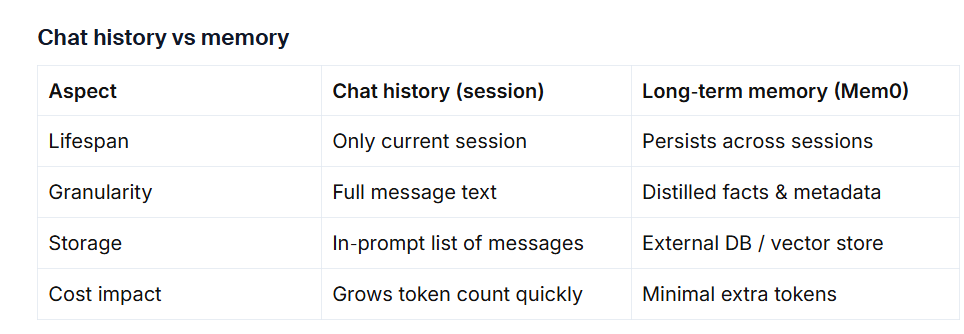

In [1]:
import os
from google.colab import userdata

In [2]:
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [3]:
os.environ["OPENAI_API_KEY"] = userdata.get('GROQ_API_KEY')

In [4]:
os.environ["OPENAI_BASE_URL"] = "https://api.groq.com/openai/v1"

In [6]:
### Install mem0 - Execute the cell twice in case you ovserve error in google colab

!pip install mem0ai \
             groq \
             langgraph==1.0.3 \
             langchain-groq==1.0.0


In [7]:
from mem0 import Memory


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


From the below config file we will setup

1. History database
2. Vector Store

They work together, but store different types of data.





**history_384.db** — the “metadata” or “index card” memory

Think of this like a notebook or index of what happened.

What it contains:

  1. User IDs (like "ankur01")
  2. Message text (original or summarized)
  3. Timestamps
  4. Tags or categories
  5. Pointers to embeddings stored in Qdrant


Format: It’s just a SQLite database file (like a mini Excel sheet).

You can open it with any SQLite viewer and see tables with text and metadata.

It’s small and human-readable (no huge vectors inside).

Analogy: “This note belongs to Ankur. It says he’s a Generative AI trainer. Its embedding is stored over there in Qdrant.”


---------------------------------------------------



**Qdrant — the vector store**

This is your semantic memory brain — where meanings live as numbers.

What it contains:

  1. Each memory’s vector embedding (384 numbers for each piece of text). Since the embedding model used in the below example is all-MiniLM-L6-v2

  2. Metadata like an ID or document reference.

  3. An internal index that makes similarity search lightning-fast.

Format:Stored in a binary format in the directory /tmp/qdrant_ankur_384.

You don’t edit it manually — Qdrant manages it.

Every collection in Qdrant must have a fixed vector length (384 in your case).

Analogy:“I don’t care about exact words — I remember concepts and can find things that mean the same thing.”

| Layer                                  | Purpose                                                                                              | Example file                               |
| -------------------------------------- | ---------------------------------------------------------------------------------------------------- | ------------------------------------------ |
| **1️⃣ History database (metadata)**    | Keeps *structured info* — like who said what, when, and links between memories.                      | `history_384.db` (a small SQLite file)     |
| **2️⃣ Vector store (semantic memory)** | Keeps *numerical embeddings* — the “meaning” of text as vectors so similar ideas can be found later. | Qdrant (stored in `/tmp/qdrant_ankur_384`) |


In [8]:
### Setup config

'''
You can extend the same config dict to
1. Override the LLM (provider, model, temperature, etc.)
2. Plug in a vector store for semantic search (we’ll wire up Qdrant in Section 3).
'''



# --- One consistent dimension for everything ---
DIM = 384  # all-MiniLM-L6-v2 is 384-d

config = {
    "history_db_path": "history_384.db",   # new file to avoid old schema
    "llm": {
        "provider": "groq",
        "config": {"model": "openai/gpt-oss-120b", "temperature": 0}
    },
    "embedder": {
        "provider": "huggingface",
        "config": {
            "model": "sentence-transformers/all-MiniLM-L6-v2",
            "embedding_dims": DIM            # <-- make it explicit (optional but safe)
        }
    },
    "vector_store": {
        "provider": "qdrant",
        "config": {
            "collection_name": "mem0_ankur_384",  # new collection (avoid old 1536 one)
            "embedding_model_dims": DIM,          # <-- must match embedder
            "path": "/tmp/qdrant_ankur_384",      # new storage dir so nothing stale is reused
            "on_disk": True
            # (or use host/port/url if pointing to a running Qdrant server)
        }
    }
}

In [9]:
memory = Memory.from_config(config)  # local SQLite file

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Add Memories

It uses LLM to extract important information from the conversations

In [ ]:
messages = [
      {"role": "user", "content": "Hi I'm Ankur Saxena. I am a Generative AI trainer and I love building RAG and AI Agent solutions"}
      ]

memory.add(messages, user_id = 'ankur01')


{'results': [{'id': 'bd826a74-c73b-45a6-b878-52f6005a24f8',
   'memory': 'Name is Ankur Saxena',
   'event': 'ADD'},
  {'id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
   'memory': 'Is a Generative AI trainer',
   'event': 'ADD'},
  {'id': '1fc5abe4-79c4-4070-b465-393b84c1f3d9',
   'memory': 'Loves building RAG and AI Agent solutions',
   'event': 'ADD'}]}

In [ ]:
messages = [
    {"role": "user", "content": "I have a background of Data Science and Machine Learning"}
    ]

memory.add(messages, user_id = 'ankur01', metadata={"category" : "preferences"})

{'results': [{'id': 'b2c8639f-33a4-452f-9fa2-e99312c15921',
   'memory': 'Background in Data Science and Machine Learning',
   'event': 'ADD'}]}

# Search Memories

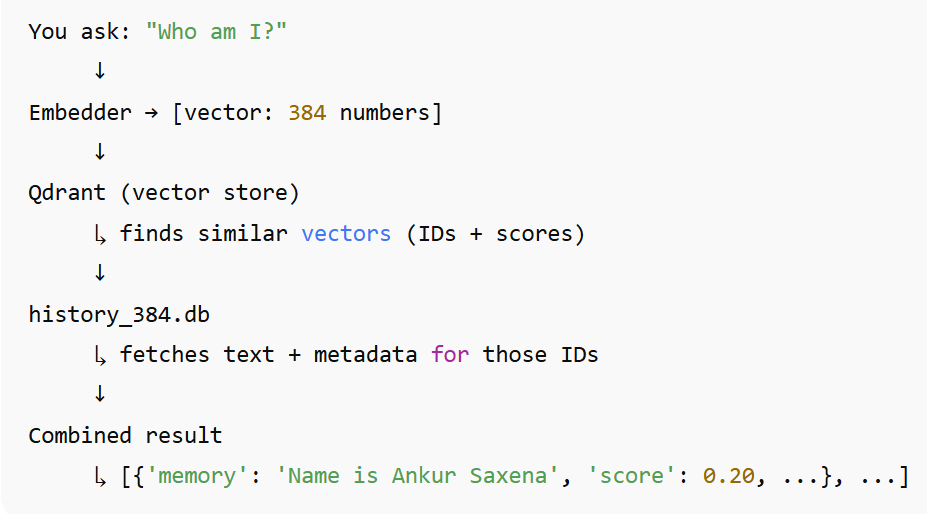

In [ ]:
related = memory.search("who am i", user_id="ankur01")
related

{'results': [{'id': 'bd826a74-c73b-45a6-b878-52f6005a24f8',
   'memory': 'Name is Ankur Saxena',
   'hash': '4a6db12ecd8e6598d3ceded68043acc2',
   'metadata': None,
   'score': 0.20677400531464218,
   'created_at': '2025-11-12T16:51:22.574642-08:00',
   'updated_at': None,
   'user_id': 'ankur01'},
  {'id': 'b2c8639f-33a4-452f-9fa2-e99312c15921',
   'memory': 'Background in Data Science and Machine Learning',
   'hash': '1e6c5bf343562667e95cbdb433dbc509',
   'metadata': {'category': 'preferences'},
   'score': 0.12223920178162115,
   'created_at': '2025-11-12T16:51:34.351959-08:00',
   'updated_at': None,
   'user_id': 'ankur01'},
  {'id': '1fc5abe4-79c4-4070-b465-393b84c1f3d9',
   'memory': 'Loves building RAG and AI Agent solutions',
   'hash': '89c3ea276d60b6654e000cfe5bff7817',
   'metadata': None,
   'score': 0.11247270267122586,
   'created_at': '2025-11-12T16:51:22.617525-08:00',
   'updated_at': None,
   'user_id': 'ankur01'},
  {'id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
  

# Get all memories for a user

In [ ]:
all_memories = memory.get_all(user_id="ankur01")

In [ ]:
all_memories

{'results': [{'id': '1fc5abe4-79c4-4070-b465-393b84c1f3d9',
   'memory': 'Loves building RAG and AI Agent solutions',
   'hash': '89c3ea276d60b6654e000cfe5bff7817',
   'metadata': None,
   'created_at': '2025-11-12T16:51:22.617525-08:00',
   'updated_at': None,
   'user_id': 'ankur01'},
  {'id': 'b2c8639f-33a4-452f-9fa2-e99312c15921',
   'memory': 'Background in Data Science and Machine Learning',
   'hash': '1e6c5bf343562667e95cbdb433dbc509',
   'metadata': {'category': 'preferences'},
   'created_at': '2025-11-12T16:51:34.351959-08:00',
   'updated_at': None,
   'user_id': 'ankur01'},
  {'id': 'bd826a74-c73b-45a6-b878-52f6005a24f8',
   'memory': 'Name is Ankur Saxena',
   'hash': '4a6db12ecd8e6598d3ceded68043acc2',
   'metadata': None,
   'created_at': '2025-11-12T16:51:22.574642-08:00',
   'updated_at': None,
   'user_id': 'ankur01'},
  {'id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
   'memory': 'Is a Generative AI trainer',
   'hash': '7cfd5e52b227500b404f81aa636ae91f',
   'metadat

# Get a single memory by ID

In [ ]:
memory_id = "d5c0cbbd-e830-4fc6-b51e-48baf7770b91"
specific_memory = memory.get(memory_id)
specific_memory

{'id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
 'memory': 'Is a Generative AI trainer',
 'hash': '7cfd5e52b227500b404f81aa636ae91f',
 'metadata': None,
 'score': None,
 'created_at': '2025-11-12T16:51:22.595671-08:00',
 'updated_at': None,
 'user_id': 'ankur01'}

# Update Memory

In [ ]:
memory_id = "d5c0cbbd-e830-4fc6-b51e-48baf7770b91"

In [ ]:
result = memory.update(memory_id=memory_id, data="He is a Python trainer")
result


{'message': 'Memory updated successfully!'}

In [ ]:
specific_memory = memory.get(memory_id)
specific_memory


{'id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
 'memory': 'He is a Python trainer',
 'hash': '8c8c23990a2daf21bf1c8860f894193d',
 'metadata': None,
 'score': None,
 'created_at': '2025-11-12T16:51:22.595671-08:00',
 'updated_at': '2025-11-12T17:38:03.220184-08:00',
 'user_id': 'ankur01'}

# View change history

In [ ]:
memory_id = "d5c0cbbd-e830-4fc6-b51e-48baf7770b91"

In [ ]:
history = memory.history(memory_id=memory_id)
history

[{'id': '43786b2e-7db2-4446-8a43-7aacc2eb25e3',
  'memory_id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
  'old_memory': None,
  'new_memory': 'Is a Generative AI trainer',
  'event': 'ADD',
  'created_at': '2025-11-12T16:51:22.595671-08:00',
  'updated_at': None,
  'is_deleted': False,
  'actor_id': None,
  'role': None},
 {'id': 'b5257ad3-9a05-442e-a76e-2ecb4dc03578',
  'memory_id': 'd5c0cbbd-e830-4fc6-b51e-48baf7770b91',
  'old_memory': 'Is a Generative AI trainer',
  'new_memory': 'He is a Python trainer',
  'event': 'UPDATE',
  'created_at': '2025-11-12T16:51:22.595671-08:00',
  'updated_at': '2025-11-12T17:38:03.220184-08:00',
  'is_deleted': False,
  'actor_id': None,
  'role': None}]

#  LangGraph Integration – Wiring Mem0 into an Agent

Below we build the LangGraph agent that:

1. Accepts user messages.

2. Retrieves relevant memories from Mem0.

3. Injects them into the system prompt for personalised replies.

4. Writes the new interaction back to Mem0.

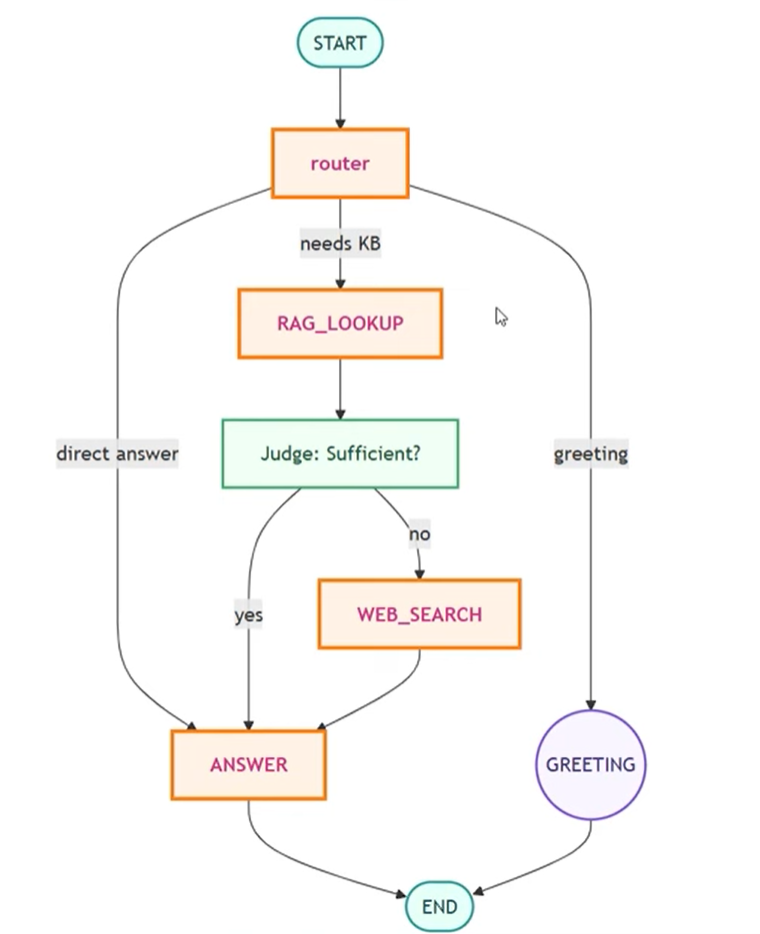

In [10]:
import os

os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT'] = "LangGraph-MeM0-test"

In [ ]:
# !pip install langgraph==1.0.3

In [ ]:
# !pip install langchain-groq==1.0.0

In [11]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class State(TypedDict):
    """Conversation state passed between nodes"""
    messages: Annotated[list[BaseMessage], add_messages]  # chat history for this request
    mem0_user_id: str                                     # maps to Mem0 user record


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:
###  Init the LLM

from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0.7)


In [13]:
### Create a Chatbot node

from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

def chatbot(state: State):
    global memory  # re‑use the Mem0 instance from Section 1
    msgs = state["messages"]
    uid = state["mem0_user_id"]

    ### 1️⃣ Retrieve memories relevant to the latest user msg
    mems = memory.search(msgs[-1].content, user_id=uid)
    print(f"Retrieved Memories: {mems}")

    ### Build context string
    if mems["results"]:
        context = "".join(f"- {m['memory']}" for m in mems["results"])
    else:
        context = "No relevant information found."

    system = SystemMessage(content=f"""You are a helpful assistant. Use the provided context to personalise your responses.
Relevant information from previous conversations:
{context}""")

    # 2️⃣ Invoke the LLM
    response = llm.invoke([system] + msgs)

    # 3️⃣ Update the memory with user and LLM response
    memory.add([
        {"role": "user", "content": msgs[-1].content},
        {"role": "assistant", "content": response.content}
    ], user_id=uid)

    return {"messages": [response]}


In [14]:
### Build and compile the graph

from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
print("Graph compiled successfully ✅")


Graph compiled successfully ✅


In [16]:
### Command‑line loop for quick testing

# from langgraph_core.messages import HumanMessage

def run_conversation(user_input: str, mem0_user_id: str):
    state = {"messages": [HumanMessage(content=user_input)], "mem0_user_id": mem0_user_id}
    result = graph.invoke(state)
    print("🤖", result["messages"][-1].content)

if __name__ == "__main__":
    uid = "1111"
    while True:
        inp = input("You: ")
        if inp.lower() in {"quit", "exit", "bye"}:
            break
        run_conversation(inp, uid)


You: do you know me ?
Retrieved Memories: {'results': [{'id': 'eb8ed0ac-4470-4690-92b8-71ba539decf8', 'memory': 'Name is Ashish', 'hash': 'ff0f59d75f43b8d4452942296fdcd748', 'metadata': None, 'score': 0.20097062765156817, 'created_at': '2025-11-13T04:41:21.526656-08:00', 'updated_at': None, 'user_id': '1111'}, {'id': '947e2605-30ad-4397-b3f6-9525a8269b19', 'memory': 'Likes non-veg, especially chicken biryani', 'hash': '3ac925d65bc8b0475a6543c1498b6688', 'metadata': None, 'score': 0.013482277090124884, 'created_at': '2025-11-13T04:41:21.545796-08:00', 'updated_at': '2025-11-13T04:41:42.678167-08:00', 'user_id': '1111'}]}
🤖 Hey Ashish! 👋  
Based on our previous chats, I know you’re a fan of non‑veg dishes—especially a good plate of chicken biryani. How’s your craving today? Got any plans for a tasty meal or something else on your mind?
You: exit


# Vector DB Setup – Configuring Mem0 with Qdrant

SQLite works for quick tests, but once memories grow you’ll want a proper vector store. Qdrant Cloud offers a generous free tier and plugs straight into Mem0.

## 1. Spin up / locate a Qdrant Cloud cluster

Grab the cluster URL and create an API key from the Qdrant dashboard.

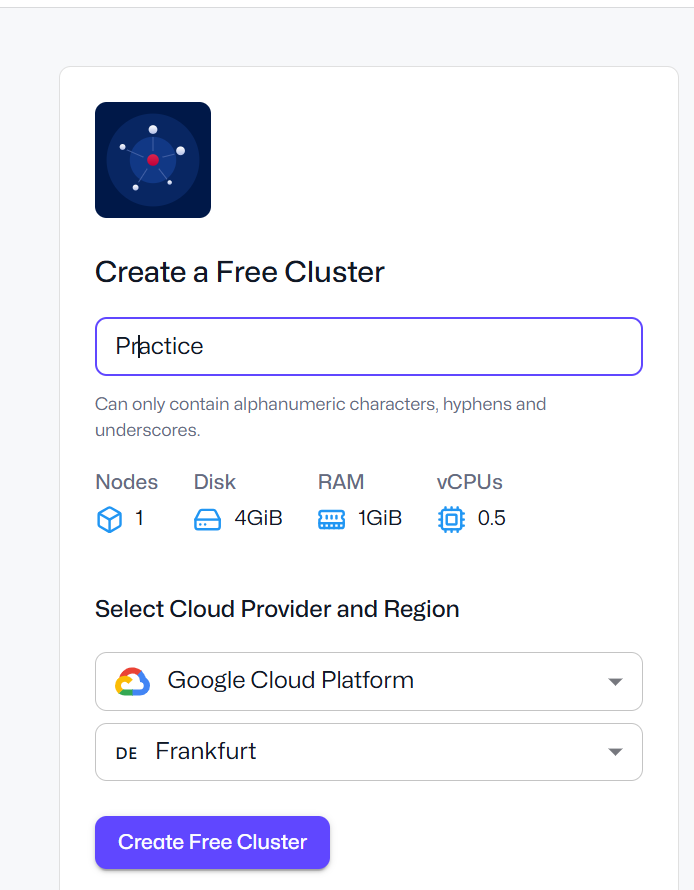

In [17]:
# Install the Python client
!pip install qdrant_client==1.15.1

In [27]:
from google.colab import userdata

In [34]:
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(
    url=userdata.get('QDRANT_HOST_URL'),
    api_key=userdata.get('QDRANT_API_KEY'),
)

print(qdrant_client.get_collections())

collections=[CollectionDescription(name='test'), CollectionDescription(name='mem0migrations')]


In [29]:
### Define collection name to be created inside vector store

collection_name = "test"

In [35]:
### Setup config

'''
You can extend the same config dict to
1. Override the LLM (provider, model, temperature, etc.)
2. Connecting with Qdrant Vector Store.
3. The documentation of setting up Qdrant vector store is not sufficient (https://docs.mem0.ai/components/vectordbs/dbs/qdrant)
4. Hence we have created our custom config that has groq llm model, hugging face embedding model, quadrant vector store
'''

# --- One consistent dimension for everything ---
DIM = 384  # all-MiniLM-L6-v2 is 384-d

config = {
    "history_db_path": "history_384_movies.db",   # new file to avoid old schema
    "llm": {
        "provider": "groq",
        "config": {"model": "openai/gpt-oss-120b", "temperature": 0}
    },
    "embedder": {
        "provider": "huggingface",
        "config": {
            "model": "sentence-transformers/all-MiniLM-L6-v2",
            "embedding_dims": DIM            # <-- make it explicit (optional but safe)
        }
    },
    "vector_store": {
        "provider": "qdrant",
        "config": {
            "collection_name": collection_name,  # new collection (avoid old 1536 one)
            "embedding_model_dims": DIM,          # <-- must match embedder
            # (use host/port/url if pointing to a running Qdrant server)
            "host": userdata.get('QDRANT_HOST_URL'),
            "port": userdata.get('QDRANT_PORT'),
            "api_key": userdata.get('QDRANT_API_KEY')
        }
    }
}

In [36]:
m = Memory.from_config(config)
messages = [
    {"role": "user", "content": "I'm planning to watch a movie tonight. Any recommendations?"},
    {"role": "assistant", "content": "How about thriller movies? They can be quite engaging."},
    {"role": "user", "content": "I’m not a big fan of thriller movies but I love sci-fi movies."},
    {"role": "assistant", "content": "Got it! I'll avoid thriller recommendations and suggest sci-fi movies in the future."}
]
m.add(messages, user_id="alice", metadata={"category": "movies"})

{'results': [{'id': 'f2232a6a-54b5-4027-84f4-56cd4fd66e5b',
   'memory': 'Planning to watch a movie tonight',
   'event': 'ADD'},
  {'id': 'e89457ae-9c21-47dc-b7c5-f0eb372d465e',
   'memory': 'Not a fan of thriller movies',
   'event': 'ADD'},
  {'id': '0af8ac21-bd02-4b34-b02e-9ca623982cbb',
   'memory': 'Loves sci-fi movies',
   'event': 'ADD'}]}

In [40]:
m.search("what I dont like watching?", user_id="alice")


{'results': [{'id': 'e89457ae-9c21-47dc-b7c5-f0eb372d465e',
   'memory': 'Not a fan of thriller movies',
   'hash': '646cbe0c51e7787e1a2a1b1d26471256',
   'metadata': {'category': 'movies'},
   'score': 0.39337337,
   'created_at': '2025-11-13T05:49:42.629269-08:00',
   'updated_at': None,
   'user_id': 'alice'},
  {'id': 'f2232a6a-54b5-4027-84f4-56cd4fd66e5b',
   'memory': 'Planning to watch a movie tonight',
   'hash': 'bf55418607cfdca4afa311b5fd8496bd',
   'metadata': {'category': 'movies'},
   'score': 0.33717638,
   'created_at': '2025-11-13T05:49:42.499765-08:00',
   'updated_at': None,
   'user_id': 'alice'},
  {'id': '0af8ac21-bd02-4b34-b02e-9ca623982cbb',
   'memory': 'Loves sci-fi movies',
   'hash': '1110b1af77367917ea2022355a16f187',
   'metadata': {'category': 'movies'},
   'score': 0.29384595,
   'created_at': '2025-11-13T05:49:42.759595-08:00',
   'updated_at': None,
   'user_id': 'alice'}]}

# Cloud Usage - MeM0 Platform

In [41]:
from google.colab import userdata

In [42]:
from mem0 import MemoryClient



### Initialize client to connect with MeM0 Platform

client = MemoryClient(api_key=userdata.get('MEM0_API_KEY'))

In [43]:
### Add a memory

messages = [
    {"role": "user", "content": "I'm a vegetarian and allergic to nuts."},
    {"role": "assistant", "content": "Got it! I'll remember your dietary preferences."}
]
client.add(messages, user_id="user123")

{'results': [{'message': 'Memory processing has been queued for background execution',
   'status': 'PENDING',
   'event_id': '2268e1b8-cdd5-4040-96bb-8e06df7ae0f2'}]}

In [44]:
### Search memories


results = client.search("What are my dietary restrictions?", filters={"user_id": "user123"})
print(results)

{'results': [{'id': '7ad1bcf6-b226-4c51-b1a1-81377b7d9cdf', 'memory': 'User is a vegetarian and allergic to nuts', 'user_id': 'user123', 'metadata': None, 'categories': ['user_preferences', 'health'], 'created_at': '2025-11-13T06:12:44-08:00', 'updated_at': '2025-11-13T06:12:44-08:00', 'expiration_date': None, 'score': 0.6165168999999999, 'structured_attributes': {'day': 13, 'hour': 14, 'year': 2025, 'month': 11, 'minute': 12, 'quarter': 4, 'is_weekend': False, 'day_of_week': 'thursday', 'day_of_year': 317, 'week_of_year': 46}}]}


In [45]:
### Adding metadata

messages = [
    {"role": "user", "content": "I like sports and keeping myself fit."},
    {"role": "assistant", "content": "Got it!"}
]
client.add(messages, user_id="user123", metadata={"category" : "fitness"})

{'results': [{'message': 'Memory processing has been queued for background execution',
   'status': 'PENDING',
   'event_id': 'b38a3d49-ba10-4ca2-ba75-bd92f2d32935'}]}

In [ ]:
### Store raw messages without inference. LLM should not extract important information from conversation but instead use the whole conversation as a memory

# client.add(messages, user_id="user123", metadata={"category" : "fitness"}, infer=False)
